ADF Statistic: -3.0909787782027847
p-value: 0.02722804259299211
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


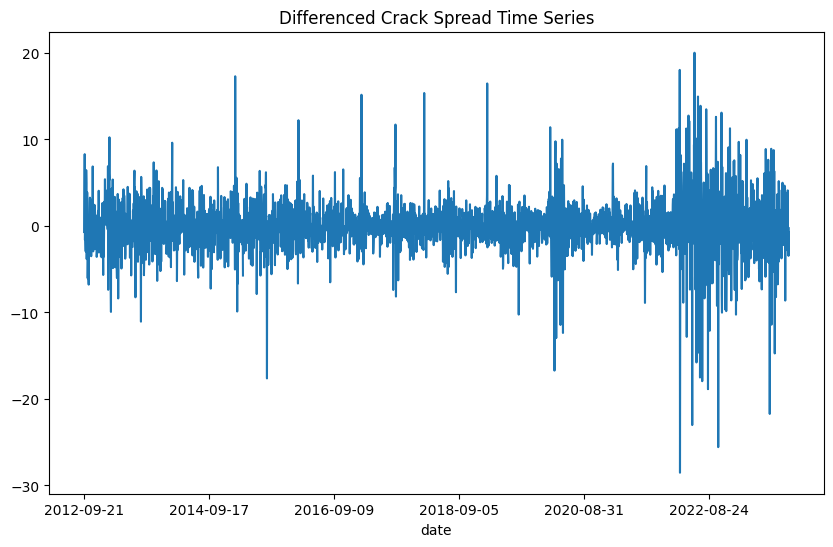

ADF Statistic (Differenced Data): -22.22073469729007
p-value (Differenced Data): 0.0
Critical Values (Differenced Data):
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [12]:
import pandas as pd
from scipy.spatial import KDTree
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle
from matplotlib import cm
from math import sin, cos, sqrt, atan2, radians
import matplotlib.dates as mdates
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the CSV data
file_path = 'eod.csv'
data = pd.read_csv(file_path)

# # convert HO and RB prices to per barrel
# data.loc[data['prs'].str.contains('HO') | data['prs'].str.contains('RB'), ['settle']] *= 42

# Revised Step 1: Identify the year and month of the contracts with the maximum sum of traded volumes for CL, RB, and HO for each day
# Grouping the data by date, year, and month, then summing the total volumes for these groups
grouped_data = data.groupby(['date', 'yr', 'mon']).sum()['totvlm'].reset_index()

# Finding the year and month combination with the maximum summed trading volume for each day
max_vol_dates = grouped_data.loc[grouped_data.groupby('date')['totvlm'].idxmax()]

# Merging the original data with the max_vol_dates to get the settle prices for the contracts with the highest volumes
merged_data = pd.merge(data, max_vol_dates, on=['date', 'yr', 'mon'])

# Step 2: Calculate the crack spread for each day
# Pivot the merged_data to make it easier to calculate the crack spread
pivot_data = merged_data.pivot_table(index='date', columns='prs', values='settle', aggfunc='first')

# Calculate the crack spread: [2 * Gasoline Price + 1 * Heating Oil Price - 3 * Crude oil price]
pivot_data['crack_spread'] = 2 * pivot_data['RB'] * 42 + pivot_data['HO'] * 42 - 3 * pivot_data['CL']

# # Plotting the daily crack spread values with x-tick labels every June and December
# plt.figure(figsize=(12, 6))
# plt.plot(pd.to_datetime(pivot_data.index), pivot_data['crack_spread'], label='3:2:1 Crack Spread', color='blue')

# # # Formatting the x-axis to display labels every June and December
# # six_month_locator = mdates.MonthLocator(bymonth=(6, 12))
# # plt.gca().xaxis.set_major_locator(six_month_locator)
# # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# # # Adding labels and title
# # plt.xlabel('Date')
# # plt.ylabel('Crack Spread Value')
# # plt.title('Daily 3:2:1 Crack Spread Over Time')
# # plt.xticks(rotation=45)
# # plt.legend()

# # # Displaying the plot
# # plt.grid(True)
# # plt.tight_layout()
# # plt.show()


# Conduct the Augmented Dickey-Fuller test
adf_result = adfuller(pivot_data['crack_spread'].dropna())

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Differencing the data
pivot_data['differenced_crack_spread'] = pivot_data['crack_spread'].diff().dropna()

# Plot the differenced data to visually inspect it
pivot_data['differenced_crack_spread'].plot(figsize=(10, 6))
plt.title('Differenced Crack Spread Time Series')
plt.show()

adf_result_diff = adfuller(pivot_data['differenced_crack_spread'].dropna())

print('ADF Statistic (Differenced Data):', adf_result_diff[0])
print('p-value (Differenced Data):', adf_result_diff[1])
print('Critical Values (Differenced Data):')
for key, value in adf_result_diff[4].items():
    print('\t%s: %.3f' % (key, value))






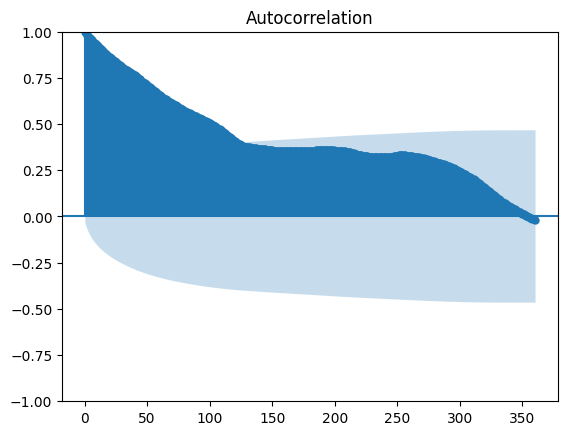

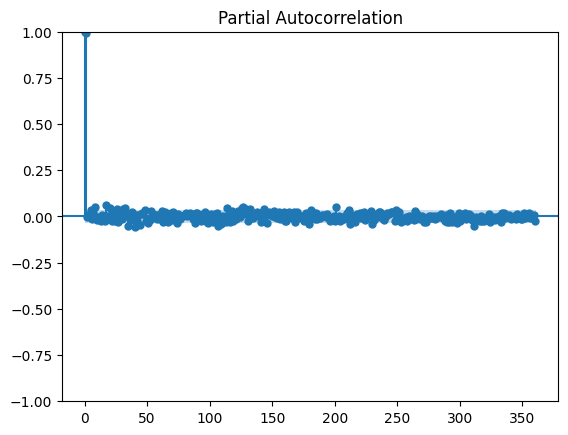

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plot_acf(pivot_data['crack_spread'].dropna(), lags=360)
plot_pacf(pivot_data['crack_spread'].dropna(), lags=360)
plt.show()


In [9]:
from statsmodels.tsa.arima.model import ARIMA

p = 1
q = 1
# Replace p, d, q with your identified parameters
model = ARIMA(pivot_data['crack_spread'], order=(p, 1, q))
results = model.fit()

# Print out the summary of the model
print(results.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           crack_spread   No. Observations:                 2820
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7313.538
Date:                Mon, 08 Apr 2024   AIC                          14633.076
Time:                        01:00:49   BIC                          14650.909
Sample:                             0   HQIC                         14639.511
                               - 2820                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9855      0.005    205.252      0.000       0.976       0.995
ma.L1         -0.9951      0.003   -347.219      0.000      -1.001      -0.990
sigma2        10.5273      0.121     86.988      0.0